In [1]:
import numpy as np
import pandas as pd 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
import torch
import torch.nn as nn
import torch.optim as optim


import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split

from PIL import Image # view image
import time # 
import copy
import os
import shutil

plt.ion()   # interactive mode

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using => ", device)

root_dir = "/content/drive/My Drive/product_detection/"
print("The data lies here => ", root_dir)

model_dir = root_dir + 'best_model/'
print("The best model lies here => ", model_dir)

ckp_dir = root_dir + 'checkpoint/'
print("Lastest model checkpoint lies here => ", ckp_dir)

We're using =>  cuda
The data lies here =>  /content/drive/My Drive/product_detection/
The best model lies here =>  /content/drive/My Drive/product_detection/best_model/
Lastest model checkpoint lies here =>  /content/drive/My Drive/product_detection/checkpoint/


## Prepare dataset
1. Load dataset
2. Split it into train, validation

In [3]:
# Define transforms
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [4]:
# Initialize Datasets
# Train data floders with be divied into train + val
product_dataset = datasets.ImageFolder(root=root_dir+"train/train",
                                      transform=image_transforms["train"])
class_names = product_dataset.classes
product_dataset

Dataset ImageFolder
    Number of datapoints: 105392
    Root location: /content/drive/My Drive/product_detection/train/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
               RandomHorizontalFlip(p=0.5)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
demo_size = 0.02 # 2K
demo_len = int(demo_size*len(product_dataset))
tiny_dataset, _ = random_split(product_dataset, [demo_len, len(product_dataset)-demo_len])
tiny_dataset

### Use tiny dataset contains of 4,000 images

In [6]:
demo = False 
if demo == True:
    print("we're using demo small dataset.")
    input_dataset = tiny_dataset
else:
    print("we're using normal big dataset")
  input_dataset = product_dataset

In [7]:
# Get train and validation samples
# SubsetRandomSampler
input_dataset_size = len(input_dataset)
input_dataset_indices = list(range(input_dataset_size))

np.random.shuffle(input_dataset_indices)
val_split_index = int(np.floor(0.2 * input_dataset_size))

train_idx, val_idx = input_dataset_indices[val_split_index:],\
input_dataset_indices[:val_split_index]

# train, val samplers
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
# train, val dataloaders
batch_size = 32
dataloaders = {
    "train": DataLoader(input_dataset, shuffle=False, 
                           batch_size=batch_size, sampler=train_sampler),
    "val": DataLoader(input_dataset, shuffle=False, 
                        batch_size=batch_size, sampler=val_sampler)
}
dataset_sizes = {'train': input_dataset_size-val_split_index, 
                 'val': val_split_index}

In [8]:
dataset_sizes

{'train': 1686, 'val': 421}

## Data Augmentation
1. mixcut
2. data generator

## Load pre-trained model & Model save
1. EfficentNet trained on Imagenet. pytorch efficientnet
2. Freeze weight of previous layers
3. Change output layers from 1000(ImageNet) to 42 
4. save trained models to Google drive

In [10]:
#using efficientnet model based transfer learning
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # freeze trained model
        self.model_ft = models.resnext101_32x8d(pretrained=True, progress=True)
        # for param in self.pretrained.parameters():
        #   param.requires_grad = False
        self.l1 = nn.Linear(1000 , 256)
        self.dropout = nn.Dropout(0.75)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(256, 42)

    def forward(self, input):
        x = self.model_ft(input)
        x = x.view(x.size(0),-1)
        x = self.dropout(self.relu(self.l1(x)))
        x = self.l2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = Classifier().to(device)

# check our model is on right device
print("Our classifier is on the device => ", list(classifier.parameters())[0].device)

Our classifier is on the device =>  cuda:0


In [11]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [12]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # initialize valid_acc_best from checkpoint to valid_acc_best
    valid_acc_best = checkpoint['valid_acc_best']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item(), valid_acc_best.item()

## Loss function, optimizer
1. Softmax, cross_entropy
2. Adam

In [13]:
criterion = nn.CrossEntropyLoss()
# observe that all parameters are being optimized
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## Train
1. hyperparameter
2. Use EfficientNet as feature extractor

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, checkpoint_path=None, best_model_path=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            CNT = 0
            # Iterate over data.
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                batchsize = inputs.size(0)
                running_loss += loss.item() * batchsize
                running_corrects += torch.sum(preds == labels.data)
                CNT += 1
                if batch_idx % 10 == 0:
                  print('   {}:  [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAcc: {:.6f}'.format(phase,
                        CNT*batchsize, dataset_sizes[phase], 100. * CNT/len(dataloaders[phase]),
                        running_loss/(CNT*batchsize), running_corrects.double()/(CNT*batchsize)))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # create checkpoint variable and add important data
            checkpoint = {
                'epoch': epoch + 1,
                'valid_loss_min': epoch_loss,
                'valid_acc_best': epoch_acc,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict()
                }            
            # deep copy and save the model
            if phase == 'val':
                if epoch_acc >= best_acc:
                    save_ckp(checkpoint, True, checkpoint_path, best_model_path)
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                else:
                    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
model_final = train_model(classifier, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=1, checkpoint_path=ckp_dir+'current_checkpoint.pt',
                       best_model_path=model_dir+'best_model.pt')

Epoch 0/0
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


   train:  [32/1686 (2%)]	Loss: 4.260623 	Acc: 0.000000
   train:  [352/1686 (21%)]	Loss: 3.994062 	Acc: 0.028409
   train:  [672/1686 (40%)]	Loss: 3.938998 	Acc: 0.025298
   train:  [992/1686 (58%)]	Loss: 3.896650 	Acc: 0.027218
   train:  [1312/1686 (77%)]	Loss: 3.866509 	Acc: 0.028963
   train:  [1632/1686 (96%)]	Loss: 3.847372 	Acc: 0.029412
train Loss: 3.8451 Acc: 0.0285

   val:  [32/421 (7%)]	Loss: 3.726774 	Acc: 0.031250
   val:  [352/421 (79%)]	Loss: 3.750658 	Acc: 0.017045
val Loss: 3.7481 Acc: 0.0214

Training complete in 22m 59s
Best val Acc: 0.021378


## Verify if the model are saved

In [16]:
%ls ./drive/My\ Drive/product_detection/best_model

best_mode.pt


## Model visualization

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

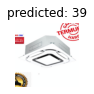

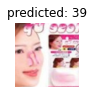

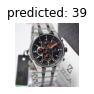

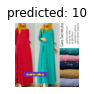

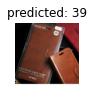

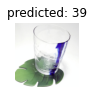

In [18]:
visualize_model(model_final)

plt.ioff()
plt.show()

## Prediction


In [21]:
# load the saved checkpoint
model = Classifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
load_path = model_dir+'best_model.pt'
model, optimizer, start_epoch, valid_loss_min, valid_acc_best = load_ckp(load_path, model, optimizer)

KeyError: ignored

In [ ]:
print("model = ", model)
print("optimizer = ", optimizer)
print("start_epoch = ", start_epoch)
print("valid_loss_min = ", valid_loss_min)
print("valid_loss_min = {:.6f}".format(valid_loss_min))
print("valid_acc_best = ", valid_acc_best)

In [ ]:
# make prediction
